In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import pickle

from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

%matplotlib inline
np.random.seed(0)

In [0]:
from google.colab import drive
drive.mount('/content/data')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/data


In [0]:
os.chdir('/content/data/My Drive/DL_Assignment_2')

In [0]:
###### Data import #############
...
'''mapping = {'coast':0,'forest':1,'insidecity':2,'mountain':3,'street':4}

X = []
Y = []
for folder, label in zip(mapping.keys(), mapping.values()):
  folder_path = os.path.join('./Data_1', folder)
  for filename in os.listdir(folder_path):
      file_path = os.path.join(folder_path, filename)
      f = open(file_path, 'r')
      x = f.read().split()
      X.append([float(i) for i in x])
      Y.append(label)
      

with open("Data_1_X.pkl", "wb") as pickle_out:
    pickle.dump(X, pickle_out) 

with open("Data_1_Y.pkl", "wb") as pickle_out:
    pickle.dump(Y, pickle_out) '''
    
...

Ellipsis

In [0]:
with open("./Data_1_X.pkl", "rb") as pickle_out:
    X = pickle.load(pickle_out) 

with open("./Data_1_Y.pkl", "rb") as pickle_out:
    Y = pickle.load(pickle_out)

In [0]:
X = np.array(X, np.float)
Y = np.array(Y, np.float)

#train,test splt
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)

In [0]:
###################### MLFFNN #############################
class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)
      
def heat_map(actual_train,predicted_train,actual_test,predicted_test):
    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    
    labels = ["coast","forest","insidecity","mountain","street"]
    cm1 =confusion_matrix(actual_train,predicted_train)
    df_cm1 = pd.DataFrame(cm1, index=labels, columns=labels)
                         
    cm2 =confusion_matrix(actual_test,predicted_test)
    df_cm2 = pd.DataFrame(cm2, index=labels, columns=labels)
    
    fig1 = plt.figure(1)
    
    #sn.set(font_scale=1.4)
    sn.heatmap(df_cm1, cmap="YlGnBu",annot=True,fmt='.0f',annot_kws={"size": 12})
    plt.yticks(rotation=0)
    
    fig2 = plt.figure(2)
    #sn.set(font_scale=1.4)
    sn.heatmap(df_cm2, cmap="YlGnBu",annot=True,fmt='.0f',annot_kws={"size": 12})
    plt.yticks(rotation=0)
    
    plt.show()

def MLFFNN(x_train, y_train, x_test, y_test, input_size, hidden_layer_size, learning_rate, max_epoch, error_threshold): 
  
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  torch.set_default_tensor_type('torch.DoubleTensor')
  dtype = torch.int64

  #make torch tensors 
  x_train_torch = torch.tensor(x_train); 
  x_train_torch = x_train_torch.to(device)
  y_train_torch = torch.tensor(y_train, dtype=dtype)
  y_train_torch = y_train_torch.to(device)
  
  x_test_torch = torch.tensor(x_test); 
  x_test_torch = x_test_torch.to(device)
  y_test_torch = torch.tensor(y_test, dtype=dtype)
  y_test_torch = y_test_torch.to(device)
  
  D_IN = input_size
  H = hidden_layer_size
  D_OUT = 5
  LEARNING_RATE = learning_rate
  MAX_EPOCH = max_epoch
  THRESHOLD = error_threshold
  
  '''classifier = torch.nn.Sequential(
              torch.nn.Linear(D_IN, H),
              torch.nn.ReLU(),
              torch.nn.Linear(H, D_OUT),
              torch.nn.Softmax())'''
  
  classifier = torch.nn.Sequential(
              torch.nn.Linear(D_IN, H),
              torch.nn.ReLU(),
              torch.nn.Linear(H, H),
              torch.nn.ReLU(),
              torch.nn.Linear(H, D_OUT),
              torch.nn.Softmax())
  
  train_loader = torch.utils.data.DataLoader(ConcatDataset(x_train_torch,y_train_torch), batch_size= 128, shuffle=False)


  classifier = classifier.to(device)
  loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
  optimizer = torch.optim.Adam(classifier.parameters(), lr=LEARNING_RATE)
  error_train = []
  
  ##### Training ##############
  for epoch in range(MAX_EPOCH):
    batch_loss = []
    for data in train_loader:  
      
      y_pred_train = classifier(x_train_torch)        
      loss_train = loss_fn(y_pred_train, y_train_torch)
      batch_loss.append(loss_train.item())
      
      optimizer.zero_grad()
      loss_train.backward()
      optimizer.step()
    
    mean_batch_loss = np.mean(batch_loss)
    del batch_loss
    if epoch % 50 == 0:
        print(epoch, mean_batch_loss.item())    
    error_train.append(mean_batch_loss.item())

    #early stopping criteria
    if epoch >= 5 and abs(error_train[epoch-1] - error_train[epoch]) <= THRESHOLD:
      print('Reached threshold')
      break
 
  print('number of epochs:', len(error_train))
  print('train error: ', error_train[-1])
  
  fig1 = plt.figure(1)
  plt.plot(error_train, color = 'b', label = 'training error')
  plt.legend()
  plt.xlabel('epochs')
  plt.ylabel('cross entropy')
  plt.title('cross entropy vs epochs')
  plt.show()
  
  fig1 = plt.figure(1)
  
  prediction_train = y_pred_train.cpu().detach().numpy()
  prediction_train = prediction_train.argmax(axis = 1)
  acc_train = accuracy_score(y_train, prediction_train)
  fig2 = plt.figure(2)
  print('Train accuracy:', acc_train)

  #test accuracy
  y_pred_test = classifier(x_test_torch)        
  loss_test = loss_fn(y_pred_test, y_test_torch)
  ##################
  prediction_test = y_pred_test.cpu().detach().numpy()
  prediction_test = prediction_test.argmax(axis = 1)
  acc_test = accuracy_score(y_test, prediction_test)
  print('Test accuracy:', acc_test)

  #Confusion matrix
  heat_map(y_train, prediction_train, y_test, prediction_test)
  
  ###################### Averaging Stuff ###################
  train_error = round(error_train[-1], 2)
  test_error = round(loss_test.cpu().item(), 2)
  train_accuracy = round(acc_train, 4)*100
  test_accuracy = round(acc_test, 4)*100
  
  ###############################################
  
  return classifier, train_error, train_accuracy, test_error, test_accuracy, len(error_train)

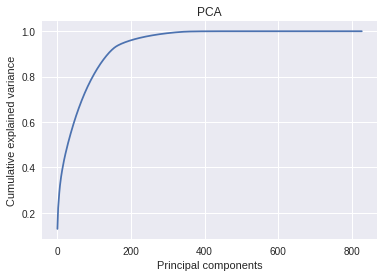

In [0]:
########## PCA ###############
pca = PCA().fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

#plot cumilative explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Principal components')
plt.ylabel('Cumulative explained variance')
plt.title('PCA')

#decide number of PCs
npca = np.sum(np.cumsum(pca.explained_variance_ratio_) <= 0.99)

In [0]:
npca

292

In [0]:
########### PCA Experiment ###########
pca_feature_size = npca
hidden_layer_size = 50
learning_rate = 1e-4
max_epoch = 10
error_threshold = 1e-5
##################################

classifier, _, _, _, _, _ = MLFFNN(x_train = x_train_pca[:,:pca_feature_size], y_train = y_train, x_test = x_test_pca[:,:pca_feature_size], y_test = y_test,
                    input_size = pca_feature_size ,hidden_layer_size = hidden_layer_size, learning_rate = learning_rate, 
                    max_epoch = max_epoch, error_threshold = error_threshold )

In [0]:
#### Auto Encoder  #############

class AutoEncoder(nn.Module):
    def __init__(self, D_in, NL, L):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(D_in, NL),
            nn.Sigmoid(),
            nn.Linear(NL, L),
        )
        self.decoder = nn.Sequential(
            nn.Linear(L, NL),
            nn.Sigmoid(),
            nn.Linear(NL, D_in),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

def AutoEncoderModel(x_train, x_test, bottle_neck_size,nonlinear_layer_size):
  
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  #torch.set_default_tensor_type('torch.DoubleTensor')
      
  x_train_torch = torch.tensor(x_train); 
  x_train_torch = x_train_torch.to(device)
  
  x_test_torch = torch.tensor(x_test); 
  x_test_torch = x_test_torch.to(device)


  D_in = 828
  NL = nonlinear_layer_size
  L = bottle_neck_size
  MAX_EPOCH = 1000
  BATCH_SIZE = 128
  LR = 1e-4        


  train_loader = torch.utils.data.DataLoader(x_train_torch, batch_size=BATCH_SIZE, shuffle=False)


  AE = AutoEncoder(D_in, NL, L)
  AE = AE.to(device)
  optimizer = torch.optim.Adam(AE.parameters(), lr=LR)
  loss_fn = torch.nn.MSELoss(reduction='mean')
  error_train = []
  for epoch in range(MAX_EPOCH):
      batch_loss = []
      for data in train_loader:  

        encoded, decoded = AE(data)

        loss = loss_fn(decoded, data)

        batch_loss.append(loss.item())
        optimizer.zero_grad()               
        loss.backward()                     
        optimizer.step()  

      mean_batch_loss = np.mean(batch_loss)
      del batch_loss
      if epoch % 100 == 0:
          print(epoch, mean_batch_loss.item())    
      error_train.append(mean_batch_loss.item())
      
      if  epoch>= 5 and error_train[epoch] <= 0.002:
        print('Reached reconstruction cut off')
        break   

      if  epoch>= 5 and abs(error_train[epoch-1] - error_train[epoch]) <= 1e-7:
        print('Reached delta error threshold')
        break     
  plt.plot(error_train, color = 'g', label = 'reconstruction error')
  plt.legend()

  plt.xlabel('epochs')
  plt.ylabel('MSE')
  plt.title('MSE vs epochs')
  plt.show()

  print('number of epochs:', len(error_train))
  print('reconstruction error: ', error_train[-1])
  print('***********************************')
  
  x_train_ae, _ = AE(x_train_torch)
  x_train_ae = x_train_ae.cpu().detach().numpy()
  x_test_ae, _ = AE(x_test_torch)
  x_test_ae = x_test_ae.cpu().detach().numpy()
  
  
  return x_train_ae,x_test_ae

0 1.761889447972713
100 0.17008989988299414
200 0.1440834815458327
300 0.12002333376877669
400 0.10227062011197421
500 0.09020407676605252
600 0.08356249583070224
700 0.08009819658942534
800 0.07835478534962724
900 0.07679384309840433


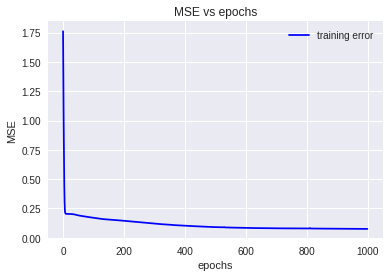

number of epochs: 1000
training error:  0.07491995398013901
***********************************
0 1.5994174746214354


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


50 1.0347125057116187
100 0.967061240645944
150 0.9580167659598208
200 0.9512924535523308
Reached threshold
number of epochs: 221
train error:  0.9491949349055981


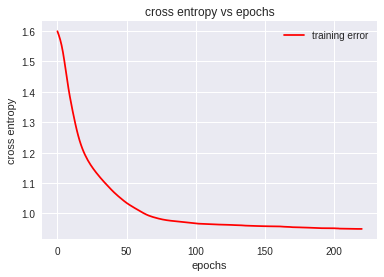

Train accuracy: 0.9541008276899925
Test accuracy: 0.6336336336336337


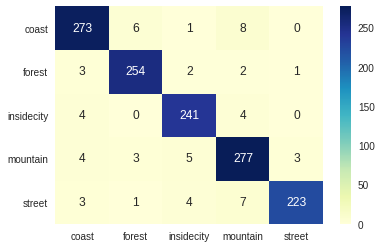

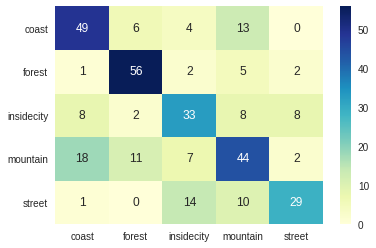

In [0]:
########## AE Experiment  ###########
bottle_neck_size = 50
hidden_layer_size = 200
learning_rate = 1e-4
max_epoch = 1000
error_threshold = 1e-4
##################################

x_train_ae,x_test_ae = AutoEncoderModel(x_train = x_train, x_test = x_test,
                                        bottle_neck_size = bottle_neck_size  ,nonlinear_layer_size = int(828*0.7))
classifier = MLFFNN(x_train = x_train_ae, y_train = y_train, x_test = x_test_ae, y_test = y_test,
                    input_size = bottle_neck_size , hidden_layer_size = hidden_layer_size, learning_rate = learning_rate,
                    max_epoch = max_epoch, error_threshold = error_threshold )